"June Gloom" is a familiar phenomenon in many parts of coastal California. Named for the month it tends to appear the most frequently, the characteristic fog or marine layer occurs due to temperature differences between the cold Pacific ocean and typically baking hot inland temperatures. Presented is an analysis of trends in occurrence of this peculiar weather pattern.

## Import packages and variables
First we import some visualization libraries. For ease of reading of the Jupyter Notebook, cleaning and feature engineering have been consolidated into june_gloom.py script, from which we import the prepared dataframes.

In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
import june_gloom
june_gloom.init()
june_gloom.noaa_clean()
june_gloom.feature_sst_anomaly()
from june_gloom import df_lax, df_enso_sst

Let's take a quick peek at our dataframe to make sure everthing loaded properly.

We can see the time format is correct (YYYY-MM-DD) and preview our columns. Note the 'FRSHTT' column; the NOAA data are encoded either '0' or '1' for each of the following events: "Fog, Rain, Snow, Hail, Thunder, Tornado" (GSOD_DESC.txt)

In [3]:
df_lax['YEARMODA'].min(), df_lax['YEARMODA'].max()

(Timestamp('1973-01-01 00:00:00'), Timestamp('2018-06-01 00:00:00'))

We have 16,588 days of data to play with. Woohoo

In [4]:
df_lax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16588 entries, 0 to 16587
Data columns (total 18 columns):
YEARMODA       16588 non-null datetime64[ns]
TEMP           16588 non-null float64
DEWP           16588 non-null float64
SLP            16588 non-null float64
STP            16588 non-null float64
VISIB          16588 non-null float64
WDSP           16588 non-null float64
MXSPD          16588 non-null float64
GUST           16588 non-null float64
MAX            16588 non-null float64
MIN            16588 non-null float64
PRCP           16588 non-null float64
SNDP           16588 non-null float64
FRSHTT         16588 non-null int64
month          16588 non-null int64
year           16588 non-null int64
dummy          16588 non-null int64
sst_anomaly    16556 non-null float64
dtypes: datetime64[ns](1), float64(13), int64(4)
memory usage: 2.3 MB


## Data preprocessing
Next, let's drop the columns we won't be using.

In [5]:
df_lax_cols = ['SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'SNDP', 'month', 'dummy', 'sst_anomaly']
df_lax.drop(df_lax_cols, axis=1, inplace=True)
df_lax = df_lax.set_index('YEARMODA')

As we can see below, the overwhelming majority of weather events observed at Los Angeles National Airport between 1973 and 2018 was 'Sun'. Sanity, check. The next most common was 'Fog', followed by 'Rain'.

In [6]:
df_lax['FRSHTT'].value_counts()

0         10009
100000     4251
10000      1169
110000      958
10010       106
110010       61
10            8
10110         4
10100         4
110100        3
1             3
100010        2
110110        2
11000         2
111100        1
1000          1
111000        1
11110         1
110011        1
11100         1
Name: FRSHTT, dtype: int64

## Exploratory data analysis
Just to get a few basic ideas of what we're working with, we can plot a few histograms to see what's going on.

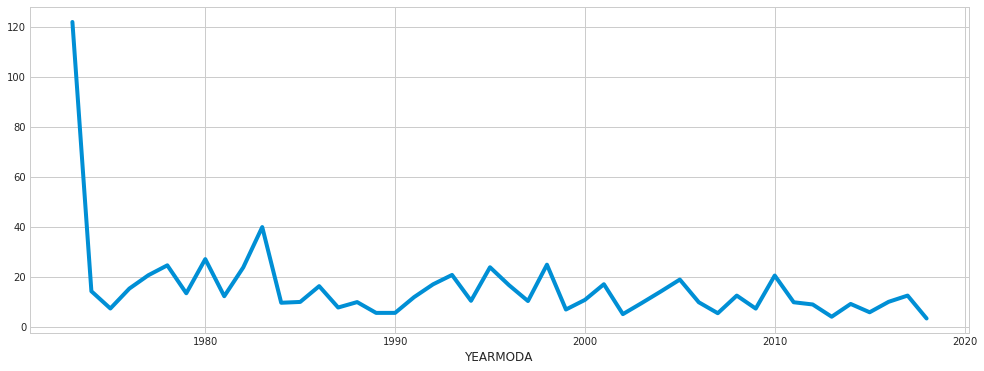

In [7]:
y = df_lax['PRCP'].resample('A').sum()
y.plot(figsize=(15, 6))
plt.show()

While most of the precipitation data looks to be within a reasonable range (LA is known to get about 14 in rain on average), 122 inches is a really extreme amount of rain in 1973. After a [preliminary fact-check online](http://www.laalmanac.com/weather/we13.php "LA Almanac") we can see this clearly is not correct. Let's take a closer look.

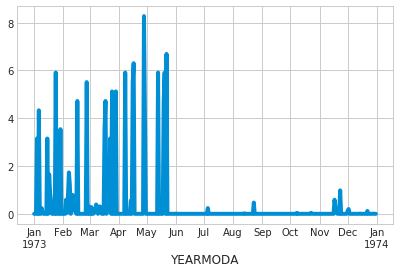

In [8]:
df_lax['1973']['PRCP'].plot()

Although the distribution of rainy days is plausible for the typical rainy season, the measurements are incredibly high. My guess is that since this was the first year of measurement, there might have been some discrepancy in the methodology of the recording. Perhaps some or all of the measurements were actually made in the metric system, such as deciliters (dL). Either way, for now let's just exclude 1973 and start from 1974 for our analysis.

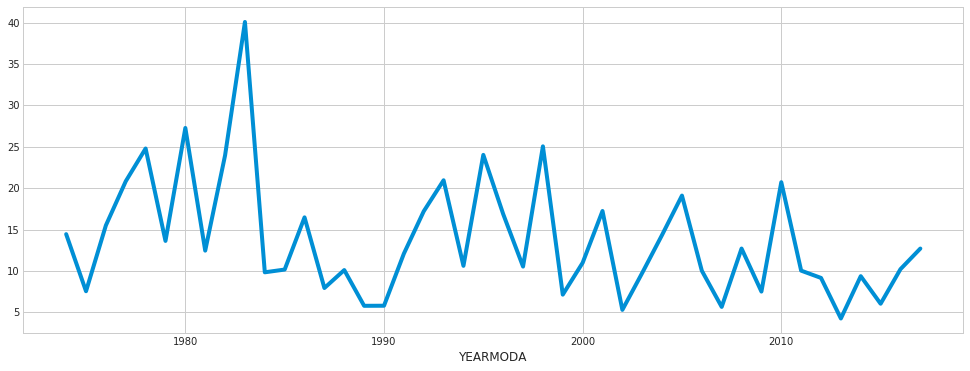

In [9]:
y = df_lax['1974':'2017']['PRCP'].resample('A').sum()
y.plot(figsize=(15, 6))
plt.show()

Obligatory climate change alarmist comment: although it's a bit noisy we can see a pretty clear downward trend in precipation since 1974...

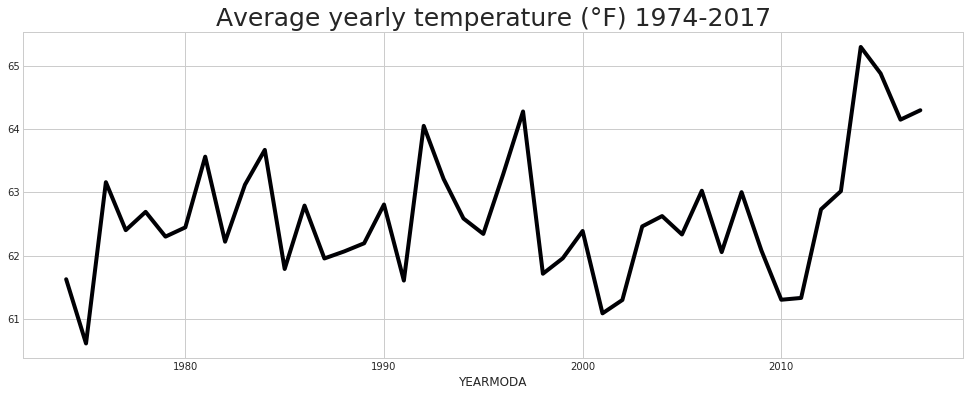

In [10]:
y = df_lax['1974':'2017']['TEMP'].resample('A').mean()
y.plot(figsize=(15, 6), colormap='magma')

plt.title("Average yearly temperature (°F) 1974-2017", fontsize=(25))
plt.show()

And some record high recent years (below)! Whuddya know..

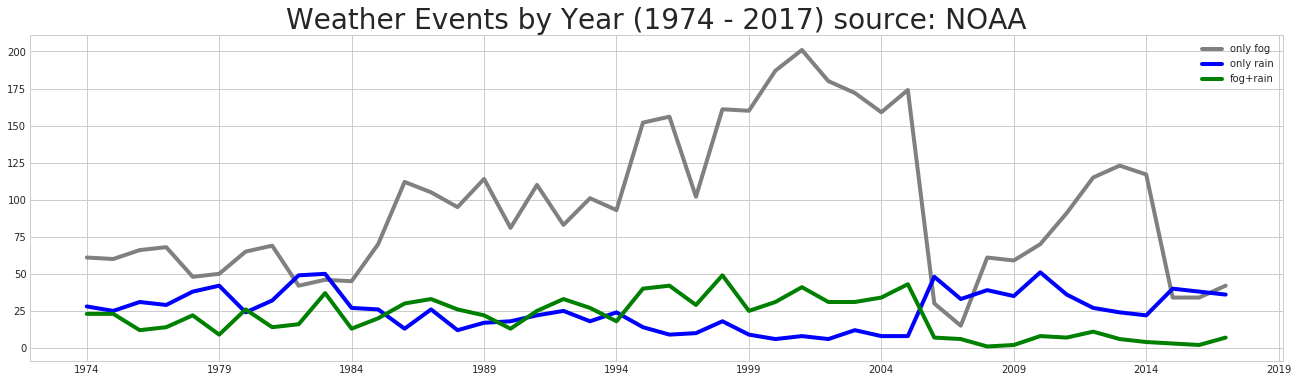

In [11]:
fig, ax = plt.subplots()

ax.plot(df_lax['1974':'2017'].loc[df_lax['FRSHTT'] == 100000].resample('AS').count()['TEMP'], 
        'grey', label='only fog')
ax.plot(df_lax['1974':'2017'].loc[df_lax['FRSHTT'] == 10000].resample('AS').count()['TEMP'], 
        'b', label='only rain')
ax.plot(df_lax['1974':'2017'].loc[df_lax['FRSHTT'] == 110000].resample('AS').count()['TEMP'], 
        'g', label='fog+rain')

fig.set_figheight(6)
fig.set_figwidth(20)

plt.legend(loc='upper right')
plt.title('Weather Events by Year (1974 - 2017) source: NOAA', fontsize=28);

There's a few points to discuss looking at this plot of yearly total weather event days. After a slow build in the number of days with fog between 1994 and 2002, sometime around 2003-2004 a major shift occurs, where we have a sudden drop in the number of foggy days, accompanied by a bump in rainy days. Meanwhile, days with both fog and rain recorded drop to near-zero levels. Perhaps this has something to do with a shift in weather patterns such as repositioning of the jet stream, or cyclical atmospheric and oceanic events, such as the El Niño–Southern Oscillation (ENSO) or the Pacific Decadal Oscillation (PDO).

In [12]:
# May Gray, June Gloom, July, Faugust
df_lax['1974':'2017'].loc[df_lax['FRSHTT'] == 100000].resample('MS').count().head()

,TEMP,DEWP,MAX,MIN,PRCP,FRSHTT,year
YEARMODA,,,,,,,
1974-01-01,4,4,4,4,4,4,4
1974-02-01,5,5,5,5,5,5,5
1974-03-01,8,8,8,8,8,8,8
1974-04-01,8,8,8,8,8,8,8
1974-05-01,1,1,1,1,1,1,1


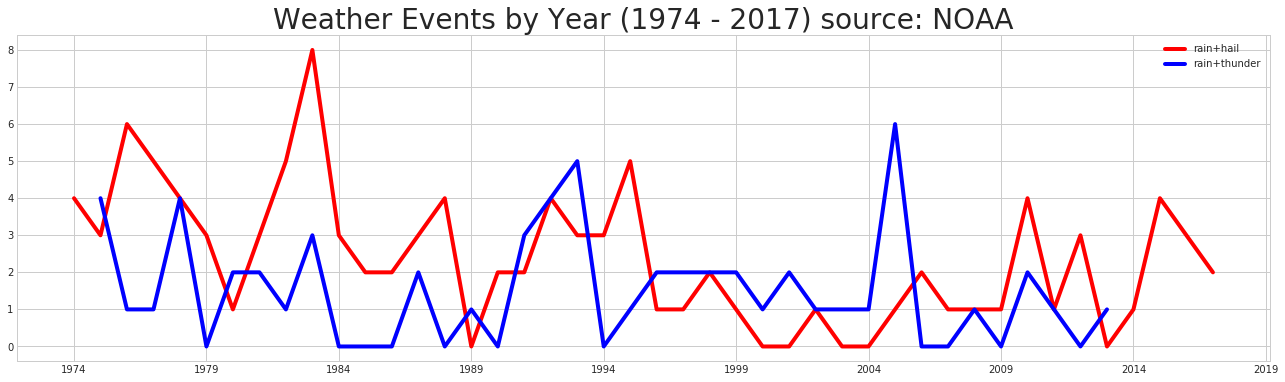

In [13]:
fig, ax = plt.subplots()

ax.plot(df_lax['1974':'2017'].loc[df_lax['FRSHTT'] == 10010].resample('AS').count()['TEMP'], 
        'r', label='rain+hail')
ax.plot(df_lax['1974':'2017'].loc[df_lax['FRSHTT'] == 110010].resample('AS').count()['TEMP'], 
        'b', label='rain+thunder')

fig.set_figheight(6)
fig.set_figwidth(20)

plt.legend(loc='upper right')
plt.title('Weather Events by Year (1974 - 2017) source: NOAA', fontsize=28);

In [19]:
df_lax['1973']['PRCP'].sum()

122.06

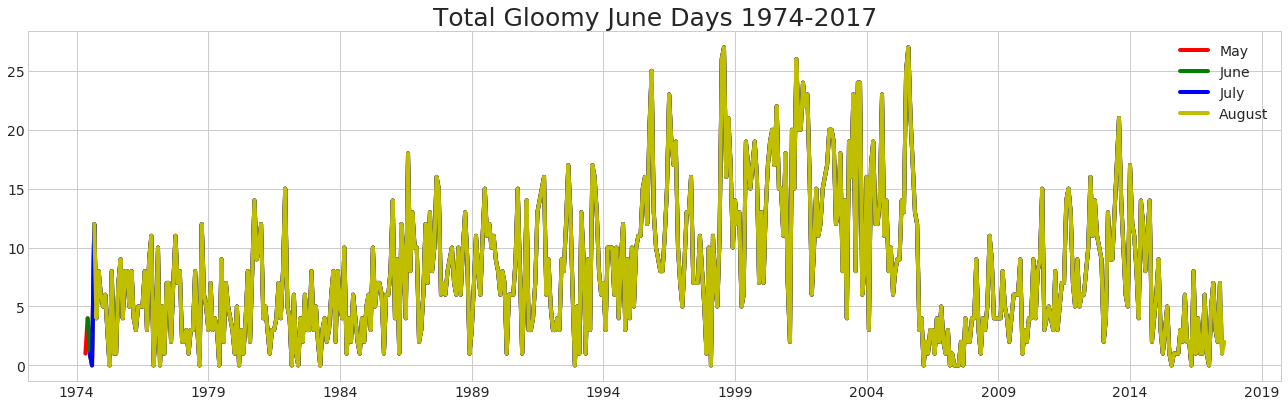

In [40]:
fig, ax = plt.subplots()

ax.plot(df_lax['1974-05':'2017-05'].loc[df_lax['FRSHTT'] == 100000].resample('MS').count()['TEMP'], 
        'r', label='May')
ax.plot(df_lax['1974-06':'2017-06'].loc[df_lax['FRSHTT'] == 100000].resample('MS').count()['TEMP'], 
        'g', label='June')
ax.plot(df_lax['1974-07':'2017-07'].loc[df_lax['FRSHTT'] == 100000].resample('MS').count()['TEMP'], 
        'b', label='July')
ax.plot(df_lax['1974-08':'2017-08'].loc[df_lax['FRSHTT'] == 100000].resample('MS').count()['TEMP'], 
        'y', label='August')

fig.set_figheight(6)
fig.set_figwidth(20)

plt.title("Total Gloomy June Days 1974-2017", fontsize=(25))
plt.legend(loc='upper right')

In [54]:
df_lax['1974':'2017'].loc[df_lax['FRSHTT'] == 10000].groupby(, axis=1)

KeyError: '%M'